In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sp

import matplotlib.pyplot as plt
import seaborn as sns

import os

from sklearn import linear_model, ensemble, discriminant_analysis
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, log_loss, auc, roc_auc_score

from functions.pipeline import *

In [2]:
SEED = 123
np.random.seed(SEED)

In [3]:
p = os.path.dirname(os.path.realpath(__name__))
path = f"{p}/data/data.csv"
df = pd.read_csv(path)
matrix, target = Gx.processing(df)

In [4]:
df.head(2)

,subject,condition,replication,leg,joint,time,angle
0,1,1,1,1,1,0,4.682881
1,1,1,1,1,1,1,5.073127


In [5]:
matrix.head(2)

left_ankle  left_knee   left_hip  right_ankle  right_knee  \
trial time                                                              
1     0       4.682881   3.693683  16.607868     5.015829    2.244425   
      1       5.073127   4.258876  16.851029     5.291201    3.381678   

            right_hip  
trial time             
1     0      18.94829  
      1      19.26530

In [6]:
target.head(2)

1    1
2    1
Name: condition, dtype: int64

<Axes: xlabel='time'>

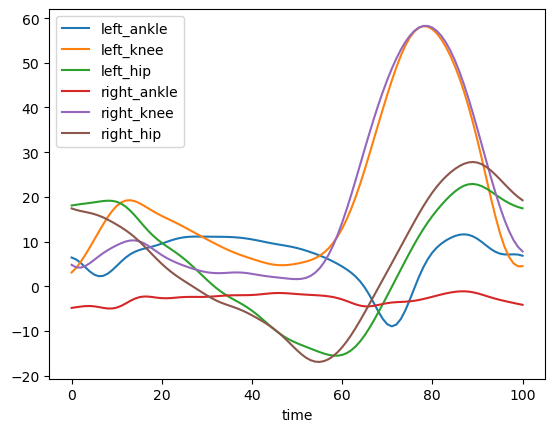

In [7]:
# knee brace
subject_no = 1
condition_no = 3
rep_no = 5
idx = (N_REPS * N_CONDITIONS) * (subject_no - 1) + N_REPS * (condition_no - 1) + (rep_no % N_REPS)
matrix.loc[idx, :].plot()

# Feature Extraction

In [8]:
means = matrix.groupby("trial").mean()
means.columns=[f"{col}_mean" for col in matrix.columns]
stdevs = matrix.groupby("trial").std()
stdevs.columns=[f"{col}_stdev" for col in matrix.columns]

In [9]:
stdev_ra = matrix["right_ankle"].groupby("trial").std()
stdev_rk = matrix["right_knee"].groupby("trial").std()

In [11]:
# need to write the code to set up all the parts of the covariance/correlation features (by splitting the matrix into 1, 2, 3 and 4 parts)

In [97]:
n_time_splits = 1
time_splits = Gx.get_time_splits(matrix, n_time_splits)
corrs = pd.DataFrame()
covs = pd.DataFrame()

for i in range(n_time_splits):
    for body_part in ["ankle", "knee"]:
        
        band = time_splits[i]

        body_parts = band[[f"left_{body_part}", f"right_{body_part}"]]
        corrs[f"{body_part}_{n_time_splits}_{i+1}"] = body_parts.groupby(["trial"]).corr(method="pearson").groupby("trial")[f"right_{body_part}"].first()
        covs[f"{body_part}_{n_time_splits}_{i+1}"] = body_parts.groupby(["trial"]).cov().groupby("trial")[f"right_{body_part}"].first()

<Axes: xlabel='trial'>

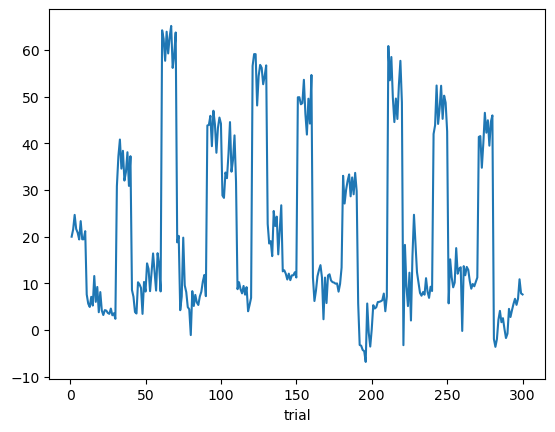

In [100]:
covs.ankle_1_1.plot()

<Axes: xlabel='trial'>

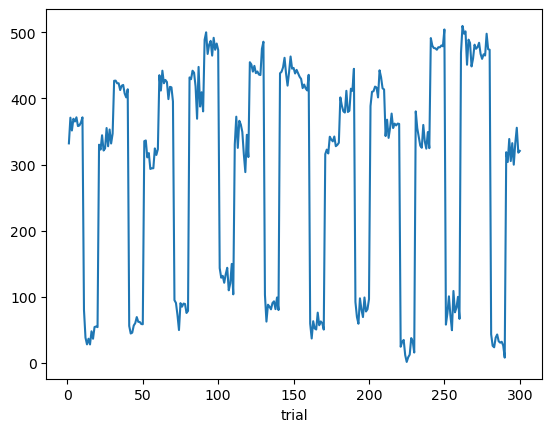

In [101]:
covs.knee_1_1.plot()

In [79]:
# two sets of features:
# base: mean of some of the sensors
# correlation model

# split the data into bands and then apply features to each band

# Testing Model

In [80]:
model = ensemble.RandomForestClassifier(n_estimators=100, max_depth=4, min_impurity_decrease=0, 
                                        bootstrap=False, criterion="log_loss")
# model = discriminant_analysis.LinearDiscriminantAnalysis(solver="svd")
# model = linear_model.LogisticRegression(max_iter=1000, multi_class="multinomial") 


In [81]:
features = pd.concat([covs], axis=1)
X_train, y_train, X_test, y_test = Gx.train_test_split(features, target)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(210, 8) (210,)
(90, 8) (90,)


In [82]:
# here we will use cross validation, leaving out 1 subject each time!
n_folds = TRAIN_SUBJECTS
cv_splits = Gx.cross_validation_splits(X_train, y_train, n_folds)
errors_valid = np.zeros(n_folds)

for i in range(len(cv_splits)):
   
   CV_X_train, CV_y_train, CV_X_valid, CV_y_valid = cv_splits[i].values()
   errors_valid[i], y_probs = Gx.run_model(CV_X_train, CV_y_train, CV_X_valid, CV_y_valid, model)

errors_valid

For fold 0
	train_inputs.shape = (180, 8)
	train_targets.shape = (180,)
	valid_inputs.shape = (30, 8)
	valid_targets.shape = (30,)
Accuracy: 0.7666666666666667
Accuracy: 0.9666666666666667
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0


array([0.27352513, 0.13376231, 0.07521939, 0.05868576, 0.086669  ,
       0.03824438, 0.11425299])

In [83]:
error_test, y_test_probs = Gx.run_model(X_train, y_train, X_test, y_test, model)
error_test

Accuracy: 1.0


0.05432222945340408

<Axes: >

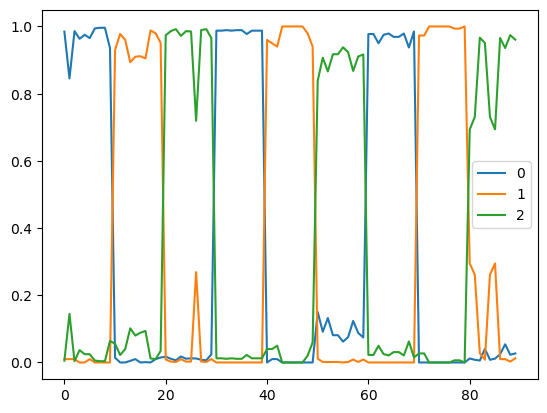

In [84]:
pd.DataFrame(y_test_probs).plot()

In [20]:
# ten subjects
# ten replications
# three conditions

# 6 measurements for each one (two legs, three joints)
# time series are 101 points long
# so the data is actually (300 x 101 x 6), so we should represent it as such.

# train-test split: 
# 7 subjects for train: should do leave-one-out validation (as in 1 subject each time)
# 3 subjects for test: leave three subjects for test

In [21]:
# to do:

# create cov features by splitting the data (e.g. first half / second half)